In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import json
from itertools import product

from keras.models import Sequential, load_model
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
# n_sample = 200_000

In [3]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy")) #[-n_sample:]
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy")) #[-n_sample:]
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

## Start of boilerplate

### Some custom definitions
* metrics
* loss functions
* learning hyper-parameters and settings

In [4]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [5]:
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
                'my_crossE': my_crossE,\
                'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

In [6]:
# auxiliary function
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history, with_lr=False):
    
    n_plots = 3 if with_lr else 2
    plt.figure(figsize=(6*n_plots, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, n_plots, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, n_plots, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    if with_lr:
        plt.subplot(1, 3, 3)
        lr = history['lr'] # learning rate
        plt.plot(x, lr, 'k', label='Learning rate')
        plt.title('Learning rate')  
        plt.legend()
    

In [7]:
working_dir = "results_keras_9"
! mkdir results_keras_9

mkdir: cannot create directory ‘results_keras_9’: File exists


In [8]:
# the workhorse
class BlackBox():
    
    def __init__(self, layers, loss, batch_size, optimizer, epochs,\
                 metrics=my_metrics,\
                 verbose=0,\
                 callbacks=None,\
                 embedd = None, embedd_dims=[None]*3, train_weights=True,\
                 mask_zeros=True
                ):
        
        self.layers = layers
        self.loss = loss
        self.loss_name = self.loss.__name__ if self.loss != 'categorical_crossentropy' else 'cat-cross'
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.metrics = metrics
        self.verbose = verbose
        self.callbacks = callbacks
        if loss == 'categorical_crossentropy':
            self.class_weight = class_weights
        else:
            self.class_weight = None
        self.train_weigts = train_weights
        self.mask_zeros = mask_zeros
        
        self.history = None
        self.test_results = None
        self.val_score = None
                
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts,\
                                     mask_zero=self.mask_zeros))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        
        self.name = f"{self.loss_name}_batch{self.batch_size}_{self.optimizer}"
        self.describe = f"loss={self.loss_name}, batch_size={self.batch_size}, optimizer={self.optimizer}, explicit-class-weights: {type(self.class_weight)==np.ndarray}, embedd-trainable: {self.model.layers[0].trainable}"

    
    def summary(self):
        print(self.describe)
        return self.model.summary()
    
    def fit(self):
        print(self.describe)
              
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=self.batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = self.verbose        
            ).history
        self.val_score = self.history['val_macroF1'][-1]
        print(f"Last val_macroF1: {self.val_score}")

        
    def evaluate(self, X_test, y_test):
        
        print(f'Loss function: {self.loss_name}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.model.evaluate(X_test, y_test)
    
    def plot(self, with_lr=False, from_file=False):
        print(self.describe)
        try:
            if not from_file:
                plot_history(self.history, with_lr=with_lr)
            else:
                hist = json.load(open(os.path.join(working_dir, f"{self.name}_history.p"), "r"))
                plot_history(hist, with_lr=with_lr)
        except:
            print("nope!")
        
    def save_embedd(self):
        file = os.path.join(working_dir, f"{self.name}_weights.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self):
        file = os.path.join(working_dir, f"{self.name}_Kmodel.h5")
        self.model.save(file)
        
    def discard(self):
        self.model = None # this doesn't seem to free the memory...
    
    def save_hist(self):
        file = os.path.join(working_dir, f"{self.name}_history.p")
        with open(file, 'w') as f:
            json.dump(self.history, f)


In [9]:
# # choose callbacks to be given in model.fit(...)


# # If the embedding layer is given to BlackBox from a file
# # and it is set to not be trainable,
# # it may yet be unfrozen at a fixed epoch or by piggybacking on the ReducLROnPlateau callback

# class WakeEmbedding(Callback):
    
#     def __init__(self, alarm_epoch=10, rel_lr_treshold=0.9):
#         self.alarm_epoch
#         self.rel_lr_treshold = rel_lr_treshold
    
#     def on_train_begin(self, logs={}):
#         self.init_lr =  K.eval(self.model.optimizer.lr)
        
#     def on_epoch_begin(self, epoch, logs={}):
#         if self.alam_epoch and epoch >= self.alam_epoch:
#             self.model.layers[0].trainable = True
#         if self.rel_lr_treshold:
#             lr =  K.eval(self.model.optimizer.lr)
#             if (lr / self.init_lr) <= self.rel_lr_treshold:
#                 self.model.layers[0].trainable = True
#         print("embedd-trainable:", self.model.layers[0].trainable)

        
# # the early-stopping is monitoring the batchwise-macroF1 (which is risky)

# def callbacks(wake_embedd=False):
    
#     callbacks = [ReduceLROnPlateau(factor=0.8,\
#                                    monitor='val_macroF1', mode='max', patience = 1),
#                 EarlyStopping(monitor='val_macroF1', mode='max', patience=3)
#                ]
    
#     return callbacks + [WakeEmbedding()] if wake_embedd else callbacks


In [10]:
epochs = 8

# our chosen parameters, see *keras_simpleGridSearch.ipynb*
batch_size = 800
optimizer = 'nadam'

In [11]:
embedd_file_catcross = os.path.join("keras_simpleGS_results", "cat-cross_batch800_nadam_weights.p")
embedd_file_myloss = os.path.join("keras_simpleGS_results", "my_loss_batch800_nadam_weights.p")

---

# Explanation
We will test four different neural-network architectures: one with mostly-dense layers, with 1D-convolution layers, simple-RNN, and LSTM. The dropout-regularization is also there. We will use separately the two loss functions considered earlier (*keras_simpleGridSearch.ipynb*) with their corresponding embedding weights preloaded but trainable. This means that the employed starting embedding layers where trained with those same loss-functions, batch_sizes, optimizers, and the same train-data, but on a simpler architecture. The rationale is the following: the simple architecture has managed to roughly group together words that belong to the same topic reaching 80% macro-F1 on validation data. Now the more complicated nets are given a chance to find some nuanced but generalizable patterns that would help to better classify the remaining 20%.

---

## Dense layers
A network with dense layers only. Note that we cannot mask zeros this time.

In [15]:
layers_dense = [Dropout(0.1),
                Dense(60, activation='relu'),
                Dense(20, activation='relu'),
                Dropout(0.1),
                Dense(10, activation='relu'),
                Dense(60, activation='relu'),
                Dropout(0.1),
                Flatten()
               ]

In [16]:
model_1a = BlackBox(layers=layers_dense, loss='categorical_crossentropy',\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,
                    embedd=embedd_file_catcross, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=False
                   )

model_1a.summary()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 679, 60)           3060      
_________________________________________________________________
dense_2 (Dense)              (None, 679, 20)           1220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 679, 20)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 679, 10)           210       
________________________________________

In [17]:
model_1a.fit()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 1477s 3ms/step - loss: 0.1951 - macroPrec: 0.7862 - macroF1: 0.7220 - macroRecall: 0.6957 - val_loss: 0.2103 - val_macroPrec: 0.8202 - val_macroF1: 0.7752 - val_macroRecall: 0.7539
Epoch 2/8
500000/500000 [==============================] - 1455s 3ms/step - loss: 0.1320 - macroPrec: 0.8884 - macroF1: 0.8417 - macroRecall: 0.8179 - val_loss: 0.2163 - val_macroPrec: 0.8428 - val_macroF1: 0.7482 - val_macroRecall: 0.7052
Epoch 3/8
500000/500000 [==============================] - 1408s 3ms/step - loss: 0.1126 - macroPrec: 0.9127 - macroF1: 0.8750 - macroRecall: 0.8559 - val_loss: 0.2228 - val_macroPrec: 0.8115 - val_macroF1: 0.7776 - val_macroRecall: 0.7634
Epoch 4/8
500000/500000 [==============================] - 1368s 3ms/step - loss: 0.0952 - macroPrec: 0.9290 - macroF1: 0.9006

In [18]:
model_1a.Ksave()
model_1a.save_hist()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True


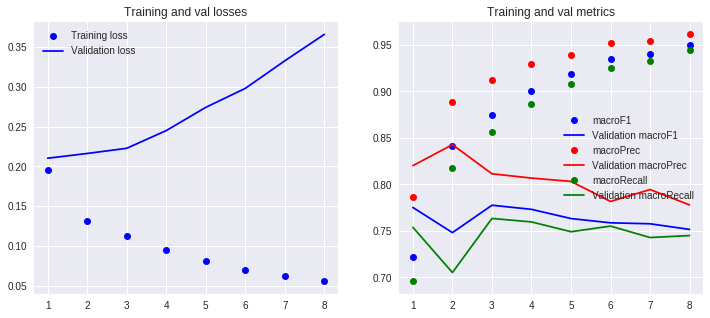

In [19]:
model_1a.plot(from_file=True)

The plots speak for themselves. The model does well at overfitting but that's about it. Let's check the custom loss function for comparison.

In [23]:
model_1b = BlackBox(layers=layers_dense, loss=my_loss,\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,
                    embedd=embedd_file_myloss, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=False
                   )

In [24]:
model_1b.fit()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 1509s 3ms/step - loss: 0.1026 - macroPrec: 0.8360 - macroF1: 0.8415 - macroRecall: 0.8690 - val_loss: 0.1563 - val_macroPrec: 0.7557 - val_macroF1: 0.7656 - val_macroRecall: 0.8211
Epoch 2/8
500000/500000 [==============================] - 1354s 3ms/step - loss: 0.0743 - macroPrec: 0.8776 - macroF1: 0.8872 - macroRecall: 0.9094 - val_loss: 0.1516 - val_macroPrec: 0.7790 - val_macroF1: 0.7810 - val_macroRecall: 0.8042
Epoch 3/8
500000/500000 [==============================] - 1314s 3ms/step - loss: 0.0629 - macroPrec: 0.8918 - macroF1: 0.9031 - macroRecall: 0.9248 - val_loss: 0.1570 - val_macroPrec: 0.7981 - val_macroF1: 0.7826 - val_macroRecall: 0.7862
Epoch 4/8
500000/500000 [==============================] - 1315s 3ms/step - loss: 0.0553 - macroPrec: 0.9042 - macroF1: 0.9150 

In [26]:
model_1b.Ksave()
model_1b.save_hist()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


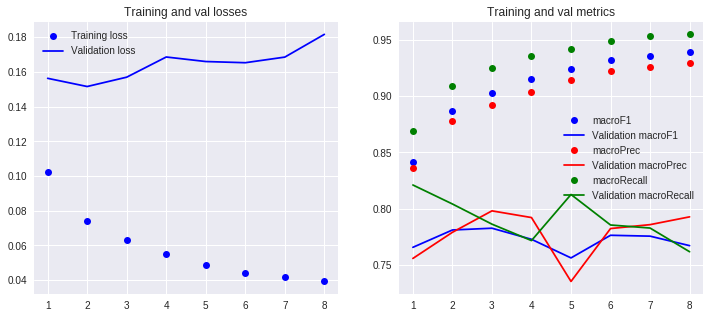

In [28]:
model_1b.plot(from_file=True)

No notable improvement.

## Commentary
The dense-network with neither loss function had any succes at extracting information from the data that would generalize to the validation dataset. From the very start of the training, the model overfits: the neural net is capable of memorizing the traindata reaching scores near 95% while the validation-score only fluctuates or slowly degrades near 77%. 

---

## Two consecutive convolution layers
Again, the zeros are not masked.

In [36]:
layers_conv = [Dropout(0.1),
               Conv1D(60, 5),
               Conv1D(30, 5),
               Flatten(),
               Dropout(0.2)
              ]

In [37]:
model_2a = BlackBox(layers=layers_conv, loss='categorical_crossentropy',\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,
                    embedd=embedd_file_catcross, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=False
                   )

model_2a.summary()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_10 (Dropout)         (None, 679, 50)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 675, 60)           15060     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 671, 30)           9030      
_________________________________________________________________
flatten_5 (Flatten)          (None, 20130)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 20130)             0         
________________________________________

In [39]:
model_2a.fit()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 2373s 5ms/step - loss: 0.1492 - macroPrec: 0.8719 - macroF1: 0.8258 - macroRecall: 0.8055 - val_loss: 0.2211 - val_macroPrec: 0.8270 - val_macroF1: 0.7690 - val_macroRecall: 0.7436
Epoch 2/8
500000/500000 [==============================] - 2190s 4ms/step - loss: 0.1226 - macroPrec: 0.9023 - macroF1: 0.8686 - macroRecall: 0.8529 - val_loss: 0.2243 - val_macroPrec: 0.8279 - val_macroF1: 0.7732 - val_macroRecall: 0.7509
Epoch 3/8
500000/500000 [==============================] - 2291s 5ms/step - loss: 0.1011 - macroPrec: 0.9195 - macroF1: 0.8948 - macroRecall: 0.8842 - val_loss: 0.2527 - val_macroPrec: 0.8247 - val_macroF1: 0.7473 - val_macroRecall: 0.7156
Epoch 4/8
500000/500000 [==============================] - 2192s 4ms/step - loss: 0.0749 - macroPrec: 0.9425 - macroF1: 0.9276

In [40]:
model_2a.Ksave()
model_2a.save_hist()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True


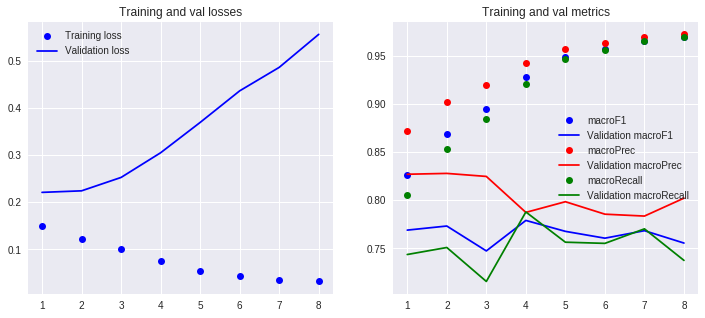

In [41]:
model_2a.plot()

Again, just overfitting.

In [42]:
model_2b = BlackBox(layers=layers_conv, loss=my_loss,\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,
                    embedd=embedd_file_myloss, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=False
                   )

In [43]:
model_2b.fit()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 2233s 4ms/step - loss: 0.0876 - macroPrec: 0.8610 - macroF1: 0.8752 - macroRecall: 0.9051 - val_loss: 0.1723 - val_macroPrec: 0.7927 - val_macroF1: 0.7916 - val_macroRecall: 0.8074
Epoch 2/8
500000/500000 [==============================] - 2279s 5ms/step - loss: 0.0959 - macroPrec: 0.8548 - macroF1: 0.8745 - macroRecall: 0.9112 - val_loss: 0.1757 - val_macroPrec: 0.7691 - val_macroF1: 0.7872 - val_macroRecall: 0.8282
Epoch 3/8
500000/500000 [==============================] - 2270s 5ms/step - loss: 0.0999 - macroPrec: 0.8495 - macroF1: 0.8708 - macroRecall: 0.9116 - val_loss: 0.1902 - val_macroPrec: 0.7792 - val_macroF1: 0.7826 - val_macroRecall: 0.8033
Epoch 4/8
500000/500000 [==============================] - 2217s 4ms/step - loss: 0.0970 - macroPrec: 0.8569 - macroF1: 0.8769 

In [45]:
model_2b.Ksave()
model_2b.save_hist()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


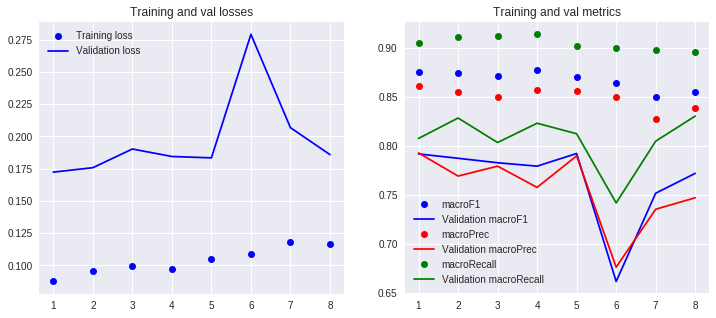

In [46]:
model_2b.plot(from_file=True)

With this loss function, the model is not capable of improving the fit even on the train data. The score on validation deteriorates with each epoch.

---

## Keras' fully connected Recurrent Network
mask_zero=True this time

In [12]:
layers_rnn = [Dropout(0.1), SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1)]

In [13]:
model_3a = BlackBox(layers=layers_rnn, loss='categorical_crossentropy',\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,\
                    embedd=embedd_file_catcross, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=True
                   )

model_3a.summary()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 13,880,906
Trainable params: 13,880,906
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_3a.fit()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 3387s 7ms/step - loss: 0.4774 - macroPrec: 0.5612 - macroF1: 0.4513 - macroRecall: 0.4288 - val_loss: 0.5252 - val_macroPrec: 0.5340 - val_macroF1: 0.4473 - val_macroRecall: 0.4340
Epoch 2/8
500000/500000 [==============================] - 3587s 7ms/step - loss: 0.5322 - macroPrec: 0.5114 - macroF1: 0.4059 - macroRecall: 0.3820 - val_loss: 0.3881 - val_macroPrec: 0.5240 - val_macroF1: 0.4563 - val_macroRecall: 0.4480
Epoch 3/8
500000/500000 [==============================] - 3186s 6ms/step - loss: 0.5386 - macroPrec: 0.4985 - macroF1: 0.3990 - macroRecall: 0.3757 - val_loss: 0.4794 - val_macroPrec: 0.4541 - val_macroF1: 0.4040 - val_macroRecall: 0.3832
Epoch 4/8
500000/500000 [==============================] - 2973s 6ms/step - loss: 0.4481 - macroPrec: 0.5226 - macroF1: 0.4359

In [15]:
model_3a.Ksave()
model_3a.save_hist()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True


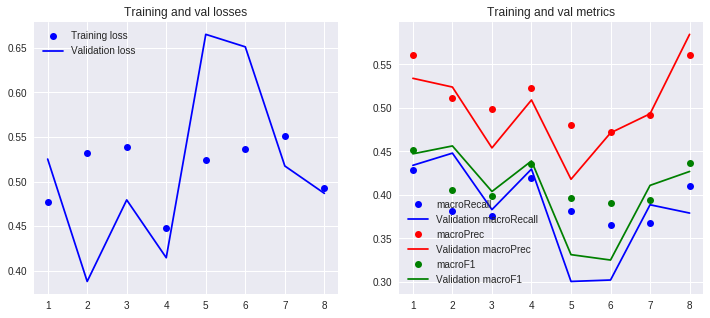

In [19]:
model_3a.plot(from_file=True)

### Commentary
Using the single SimpleRNN layer, the model is unable to even get close to the performance of global-averaging. There is no overfitting. The training destroys the information contained in the embedding layer rather than learning and storing some new information in the recurrent layer.

Try with the custom loss function for comparison

In [20]:
model_3b = BlackBox(layers=layers_rnn, loss=my_loss,\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,\
                    embedd=embedd_file_myloss, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=True
                   )

model_3b.summary()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 13,880,906
Trainable params: 13,880,906
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_3b.fit()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 3075s 6ms/step - loss: 0.3003 - macroPrec: 0.5557 - macroF1: 0.5299 - macroRecall: 0.5391 - val_loss: 0.3037 - val_macroPrec: 0.5383 - val_macroF1: 0.5242 - val_macroRecall: 0.5475
Epoch 2/8
500000/500000 [==============================] - 3390s 7ms/step - loss: 0.3173 - macroPrec: 0.5296 - macroF1: 0.5112 - macroRecall: 0.5206 - val_loss: 0.3617 - val_macroPrec: 0.4223 - val_macroF1: 0.4323 - val_macroRecall: 0.4897
Epoch 3/8
500000/500000 [==============================] - 3232s 6ms/step - loss: 0.3061 - macroPrec: 0.5377 - macroF1: 0.5242 - macroRecall: 0.5349 - val_loss: 0.2982 - val_macroPrec: 0.5745 - val_macroF1: 0.5470 - val_macroRecall: 0.5385
Epoch 4/8
500000/500000 [==============================] - 3611s 7ms/step - loss: 0.2970 - macroPrec: 0.5585 - macroF1: 0.5440 

In [22]:
model_3b.Ksave()
model_3b.save_hist()

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


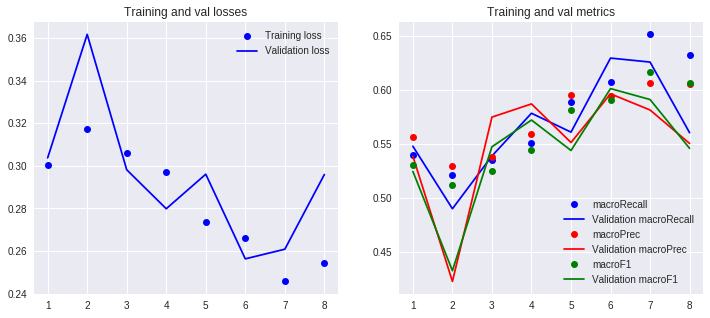

In [23]:
model_3b.plot(from_file=True)

The custom loss function doesn't do much better. The score is around 55% rather than 45% seen with the crossentropy, but that is well below the baseline of 80%.

---

## LSTMs

In [ ]:
layers_lstm = [Dropout(0.1), Birectional(LSTM(100, dropout=0.1, recurrent_dropout=0.1))]

In [ ]:
model_4a = BlackBox(layers=layers_lstm, loss='categorical_crossentropy',\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,\
                    embedd=embedd_file_catcross, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=True
                   )

model_4a.summary()

In [ ]:
model_4b = BlackBox(layers=layers_lstm, loss=my_loss,\
                    batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                    verbose=1,\
                    callbacks=None,\
                    embedd=embedd_file_myloss, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                    mask_zeros=True
                   )

model_4b.summary()